In [1]:
%matplotlib inline

from geopy.distance import distance
import pandas as pd
from time import sleep
import shapely.geometry
import pyproj
import geopandas as gpd
from matplotlib import pyplot as plt

In [7]:
# old
# MIN_LAT = 37.701933
# MAX_LAT = 38.008050
# MIN_LON = -122.536985
# MAX_LON = -122.186437

MIN_LAT = 37.2781261
MAX_LAT = 38.063446
MIN_LON = -122.683496
MAX_LON = -121.814281

In [8]:
# Set up projections
p_ll = pyproj.Proj(init='epsg:4283') # grid in lat/lon
p_mt = pyproj.Proj(init='epsg:3857') # metric; same as EPSG:900913

# Create corners of rectangle to be transformed to a grid
sw = shapely.geometry.Point((MIN_LON, MIN_LAT))
ne = shapely.geometry.Point((MAX_LON,MAX_LAT))

stepsize = 500 # 0.5 km grid step size

# Project corners to target projection
s = pyproj.transform(p_ll, p_mt, sw.x, sw.y) # Transform NW point to 3857
e = pyproj.transform(p_ll, p_mt, ne.x, ne.y) # .. same for SE

# Iterate over 2D area
boxes = []
min_lon = s[0]
x = 0
while min_lon < e[0]:
    max_lon = min_lon + stepsize
    min_lat = s[1]
    y = 0
    
    while min_lat < e[1]:
        max_lat = min_lat + stepsize
        b_left = shapely.geometry.Point(pyproj.transform(p_mt, p_ll, min_lon, min_lat))
        t_right = shapely.geometry.Point(pyproj.transform(p_mt, p_ll, max_lon, max_lat))
        
        bound_box = {'min_lat':b_left.y, 'max_lat':t_right.y, 'min_lon':b_left.x, 'max_lon':t_right.x, 'x': x, 'y':y}
        
        boxes.append(bound_box)
        min_lat = max_lat
        y += 1
    min_lon = max_lon
    x += 1

In [9]:
boxes = pd.DataFrame(boxes)

# find the center of each box
boxes['center_lat'] = (boxes.min_lat + boxes.max_lat)/2
boxes['center_lon'] = (boxes.min_lon + boxes.max_lon)/2

In [10]:
boxes.head()

,min_lat,max_lat,min_lon,max_lon,x,y,center_lat,center_lon
0,37.278126,37.281700,-122.683496,-122.679004,0,0,37.279913,-122.68125
1,37.281700,37.285274,-122.683496,-122.679004,0,1,37.283487,-122.68125
2,37.285274,37.288847,-122.683496,-122.679004,0,2,37.287060,-122.68125
3,37.288847,37.292421,-122.683496,-122.679004,0,3,37.290634,-122.68125
4,37.292421,37.295994,-122.683496,-122.679004,0,4,37.294207,-122.68125


### get shapefile of bay area

In [11]:
base = gpd.read_file("bayarea.json")

In [12]:
base.head()

,id,OBJECTID,AREA_NAME,geometry
0,s7d02x.1,1,San Francisco,"(POLYGON ((-122.381281 37.760229, -122.380781 ..."
1,s7d02x.2,2,Other,"(POLYGON ((-123.065659 38.852297, -123.062109 ..."
2,s7d02x.3,3,Bay and Ocean,"(POLYGON ((-123.79051456 37.5790828, -123.6952..."


In [13]:
## looks like row 2 is everything that corresponds to ocean
bay_and_ocean = base.loc[2, 'geometry']

In [14]:
from shapely.geometry import Point

# convert lat/lon to Point objects
boxes_as_points = boxes.apply(lambda line: Point(line.center_lon, line.center_lat), axis = 1)

In [15]:
# map every box to whether it overlaps with the bay as defined by the shapefile
boxes['in_water'] = [bay_and_ocean.contains(pt) for pt in boxes_as_points]

### visually verify this is correct

In [16]:
# convert boxes to gdf to verify that the points are correct
gdf = gpd.GeoDataFrame(boxes, geometry = boxes_as_points)

In [17]:
gdf.head()

,min_lat,max_lat,min_lon,max_lon,x,y,center_lat,center_lon,in_water,geometry
0,37.278126,37.281700,-122.683496,-122.679004,0,0,37.279913,-122.68125,True,POINT (-122.6812502117897 37.27991304197126)
1,37.281700,37.285274,-122.683496,-122.679004,0,1,37.283487,-122.68125,True,POINT (-122.6812502117897 37.2834868410625)
2,37.285274,37.288847,-122.683496,-122.679004,0,2,37.287060,-122.68125,True,POINT (-122.6812502117897 37.2870604704482)
3,37.288847,37.292421,-122.683496,-122.679004,0,3,37.290634,-122.68125,True,POINT (-122.6812502117897 37.29063393012256)
4,37.292421,37.295994,-122.683496,-122.679004,0,4,37.294207,-122.68125,True,POINT (-122.6812502117897 37.29420722007973)


(37.2781261, 38.063446)

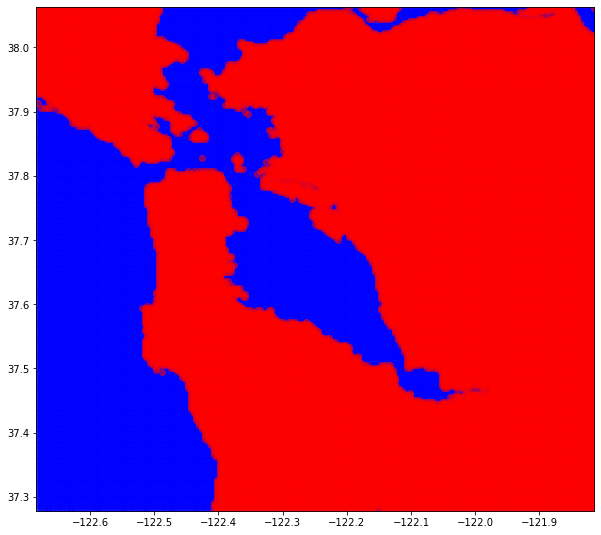

In [18]:
fig, ax = plt.subplots(figsize = (10,10))
base[base['AREA_NAME'] == 'Other'].plot(ax = ax, alpha = 0.8, color = 'grey')
base[base['AREA_NAME'] == 'San Francisco'].plot(ax = ax, alpha = 0.8, color = 'grey')
gdf[gdf['in_water'] == True].plot(ax = ax, color = 'blue', alpha = 0.5)
gdf[gdf['in_water'] == False].plot(ax = ax, color = 'red', alpha = 0.5)
ax.set_xlim(MIN_LON, MAX_LON)
ax.set_ylim(MIN_LAT, MAX_LAT)

yeah, that looks right

In [24]:
boxes[['min_lat', 'max_lat', 'min_lon', 'max_lon', 'x', 'y', 'center_lat',
       'center_lon', 'in_water', 'ndvi']].to_csv("bigger_500m_grid.csv", index = False)

In [20]:
boxes.head()

,min_lat,max_lat,min_lon,max_lon,x,y,center_lat,center_lon,in_water,geometry
0,37.278126,37.281700,-122.683496,-122.679004,0,0,37.279913,-122.68125,True,POINT (-122.6812502117897 37.27991304197126)
1,37.281700,37.285274,-122.683496,-122.679004,0,1,37.283487,-122.68125,True,POINT (-122.6812502117897 37.2834868410625)
2,37.285274,37.288847,-122.683496,-122.679004,0,2,37.287060,-122.68125,True,POINT (-122.6812502117897 37.2870604704482)
3,37.288847,37.292421,-122.683496,-122.679004,0,3,37.290634,-122.68125,True,POINT (-122.6812502117897 37.29063393012256)
4,37.292421,37.295994,-122.683496,-122.679004,0,4,37.294207,-122.68125,True,POINT (-122.6812502117897 37.29420722007973)


In [21]:
import rasterio
ndvi = rasterio.open("nn/new_ndvi.tif") # normalized vegetation index
band_n = ndvi.read(1)

In [22]:
def get_ndvi(line):
    # get ndvi
    row, col = ndvi.index(line.center_lon, line.center_lat)
    
    return band_n[row,col]

boxes['ndvi'] = boxes.apply(get_ndvi, axis =1)